In [19]:
import pandas as pd
import numpy as np
import statsmodels as sts
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [20]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.0)
plt.rcParams['grid.linewidth'] = 0.5

In [21]:
plot_features = pd.read_csv('plot_features.csv')
plot_features.head()

,movie_wikipedia_id,movie_freebase_id,movie_name,release_year,revenue,runtime,languages,countries,genres,plot_summary,...,char_count,avg_word_length,sentence_count,lexical_diversity,sentiment_polarity,topic,mood,target_audience,temporal_setting,location_setting
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th...",...,2181,6.109244,15,0.627451,-0.085095,"[""science fiction"", ""horror""]","[""dark"", ""dramatic""]","[""adults""]","[""future""]","[""fictional""]"
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...,...,3301,5.594915,36,0.542373,0.035867,"[""mystery"", ""drama""]","[""dark""]","[""adults""]","[""modern""]","[""real""]"
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra...",...,2339,5.490610,24,0.582160,0.133259,"[""drama""]","[""dark""]","[""adults""]","[""modern""]","[""real""]"
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Every hundred years, the evil Morgana returns...",...,870,5.337423,7,0.631902,0.040568,"[""fantasy"", ""adventure""]","[""inspirational""]","[""children""]","[""past""]","[""fictional""]"
4,6631279,/m/0gffwj,Little city,1997,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...","Adam, a San Francisco-based artist who works a...",...,1234,5.484444,9,0.626667,0.165202,"[""romance"", ""drama""]","[""romantic"", ""dramatic""]","[""adults""]","[""modern""]","[""real""]"


In [22]:
plot_features[['languages', 'countries', 'genres', 'topic', 'mood', 'target_audience',
       'temporal_setting', 'location_setting']] = plot_features[
            ['languages', 'countries', 'genres', 'topic', 'mood', 'target_audience',
       'temporal_setting', 'location_setting']
].applymap(json.loads, na_action='ignore')

In [25]:
plot_features[['languages', 'countries', 'genres']] = \
    plot_features[['languages', 'countries', 'genres']].applymap(
        lambda x: [y.lower() for y in x.values()], na_action='ignore')

In [26]:
set(y for x in plot_features['topic'].dropna() for y in x)

{'action',
 'adventure',
 'comedy',
 'conflict',
 'drama',
 'fantasy',
 'historical',
 'horror',
 'mystery',
 'romance',
 'science fiction',
 'tragedy'}

In [27]:
set(y for x in plot_features['topic'].dropna() for y in x) - \
    set(y for x in plot_features['genres'].dropna() for y in x)

{'conflict', 'historical', 'romance'}

In [28]:
plot_features['genres'] = (plot_features['genres'] + plot_features['topic'])\
    .map(lambda x: list(set(x)), na_action='ignore')
plot_features = plot_features.drop(columns='topic')

In [29]:
plot_features['language'].unique()

array(['en'], dtype=object)

In [30]:
plot_features = plot_features.drop(columns='language')

In [31]:
plot_features = plot_features[
    ~plot_features[['genres', 'mood', 'target_audience', 'temporal_setting', 'location_setting']]\
    .isna().any(axis=1)]

In [32]:
mood_values = set(y for x in plot_features['mood'].dropna() for y in x)
target_audience_values = set(y for x in plot_features['target_audience'].dropna() for y in x)
temporal_setting_values = set(y for x in plot_features['temporal_setting'].dropna() for y in x)
location_setting_values = set(y for x in plot_features['location_setting'].dropna() for y in x)

In [33]:

def count_llm_features(series, values):
    count_dict = dict()
    for value in values:
        count_dict[value] = series.apply(lambda x: value in x).sum()
    return dict(sorted(count_dict.items(), key=lambda x: -x[1]))

In [34]:
count_llm_features(plot_features['mood'], mood_values)

{'dramatic': 12960,
 'dark': 10002,
 'lighthearted': 5110,
 'exciting': 3008,
 'inspirational': 2902,
 'romantic': 2216,
 'fantastical': 421}

In [35]:
count_llm_features(plot_features['target_audience'], target_audience_values)

{'adults': 19930,
 'families': 2127,
 'teenagers': 2048,
 'children': 1241,
 'elderly': 16}

In [36]:
count_llm_features(plot_features['temporal_setting'], temporal_setting_values)

{'modern': 16843, 'past': 7304, 'future': 562}

In [37]:
count_llm_features(plot_features['location_setting'], location_setting_values)


{'real': 20394, 'fictional': 4947}

In [38]:
def create_cooccurrence_matrix(genres_series, feature_series):
    """
    Create a co-occurrence matrix from two pandas series: one with genres and one with feature values.

    Parameters:
    genres_series (pd.Series): A series of lists where each list contains genres.
    feature_series (pd.Series): A series of lists where each list contains feature values.

    Returns:
    pd.DataFrame: A DataFrame representing the co-occurrence matrix of genres and feature values.
    """
    # Initialize a dictionary to hold the co-occurrence counts
    cooccurrence_dict = {}

    # Iterate over the series to populate the dictionary
    for genres, feature_values in zip(genres_series, feature_series):
        for genre in genres:
            if genre not in cooccurrence_dict:
                cooccurrence_dict[genre] = {}

            for feature_value in feature_values:
                if feature_value not in cooccurrence_dict[genre]:
                    cooccurrence_dict[genre][feature_value] = 0
                cooccurrence_dict[genre][feature_value] += 1

    # Convert the dictionary to a DataFrame
    cooccurrence_matrix = pd.DataFrame(cooccurrence_dict).fillna(0).astype(int)

    # Reorder the matrix so that rows are features and columns are genres
    cooccurrence_matrix = cooccurrence_matrix.T

    return cooccurrence_matrix

In [39]:
def get_top_k_values(matrix, k, axis=0):
    """
    For each row or column in the matrix, find the top k values and return them with their labels.

    Parameters:
    matrix (pd.DataFrame): The co-occurrence matrix.
    k (int): The number of top values to return.
    axis (int): 0 to find top values in each row, 1 for each column.

    Returns:
    dict: A dictionary with rows or columns as keys and a list of tuples as values,
          where each tuple contains the label and the value of the top k items.
    """
    top_k_values = {}
    # Transpose the matrix if we are looking for top values in each column
    if axis == 1:
        matrix = matrix.T

    # Iterate over the matrix rows/columns
    for label, values in matrix.iterrows():
        # Get the top k values with their labels
        top_k = values.nlargest(k).items()
        # Store them in the dictionary
        top_k_values[label] = list(top_k)

    return top_k_values

In [40]:
create_cooccurrence_matrix(plot_features['genres'], plot_features['mood'])

,dark,dramatic,inspirational,lighthearted,exciting,romantic,fantastical
action,2620,2827,298,572,2104,171,116
space western,3,4,2,1,7,1,3
adventure,974,1855,798,1511,1744,267,285
horror,2778,1104,26,150,367,52,58
science fiction,949,799,123,258,811,59,180
...,...,...,...,...,...,...,...
the netherlands in world war ii,0,1,1,0,0,0,0
period horror,1,1,0,0,0,0,0
revisionist fairy tale,0,1,1,1,2,0,1
film-opera,0,0,0,1,0,0,0


## Regression analysis for revenues

In [46]:
plot_features.shape

(25364, 20)

In [49]:
plot_features[plot_features['revenue'].isna()]

,movie_wikipedia_id,movie_freebase_id,movie_name,release_year,revenue,runtime,languages,countries,genres,plot_summary,word_count,char_count,avg_word_length,sentence_count,lexical_diversity,sentiment_polarity,mood,target_audience,temporal_setting,location_setting
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[english language],[united kingdom],"[mystery, erotic thriller, drama, psychologica...",A series of murders of rich young women throug...,590,3301,5.594915,36,0.542373,0.035867,[dark],[adults],[modern],[real]
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[german language],[germany],[drama],"Eva, an upper class housewife, becomes frustra...",426,2339,5.490610,24,0.582160,0.133259,[dark],[adults],[modern],[real]
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,[english language],[south africa],"[adventure, fantasy, family film, world cinema]","Every hundred years, the evil Morgana returns...",163,870,5.337423,7,0.631902,0.040568,[inspirational],[children],[past],[fictional]
4,6631279,/m/0gffwj,Little city,1997,NaN,93.0,[english language],[united states of america],"[comedy, romance film, drama, romantic drama, ...","Adam, a San Francisco-based artist who works a...",225,1234,5.484444,9,0.626667,0.165202,"[romantic, dramatic]",[adults],[modern],[real]
6,18296435,/m/04cqrs4,Aaah Belinda,1986,NaN,NaN,[turkish language],[turkey],"[comedy, fantasy, mystery]","Serap, a young actress with a strong, lively p...",95,580,6.105263,6,0.747368,0.056017,[dramatic],[adults],[modern],[fictional]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25563,15394941,/m/03m6zh4,Gopi Kishan,1994,NaN,NaN,[hindi language],[india],"[action, crime, drama, comedy]",Kishan killed a man in his childhood when the...,728,4057,5.572802,55,0.467033,0.027336,"[exciting, dark, dramatic]",[adults],[modern],[real]
25565,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011,NaN,120.0,[english language],[united states of america],"[drama, mystery, science fiction]",Two former National Oceanic Atmospheric Admini...,104,664,6.384615,5,0.759615,0.108333,[dark],[adults],[modern],[real]
25566,34980460,/m/0g4pl34,Knuckle,2011,NaN,96.0,[english language],"[ireland, united kingdom]","[conflict, documentary, drama, biographical film]",{{No plot}} This film follows 12 years in the ...,64,368,5.750000,3,0.781250,0.010000,[dramatic],[adults],[modern],[real]
25567,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992,NaN,150.0,[japanese language],[japan],"[japanese movies, adventure, anime, drama, sci...","The story takes place in the year 2092,The Sup...",199,1237,6.216080,8,0.713568,0.194003,"[exciting, fantastical]",[adults],[future],[fictional]


In [48]:
plot_features['revenue'].value_counts()

revenue
2000000.0      12
6000000.0      12
4000000.0      12
12000000.0     11
3000000.0      10
               ..
134403112.0     1
3291163.0       1
1010000.0       1
1032075.0       1
1847671.0       1
Name: count, Length: 5390, dtype: int64

In [116]:
plot_features.columns

Index(['movie_wikipedia_id', 'movie_freebase_id', 'movie_name', 'release_year',
       'revenue', 'runtime', 'languages', 'countries', 'genres',
       'plot_summary', 'word_count', 'char_count', 'avg_word_length',
       'sentence_count', 'lexical_diversity', 'sentiment_polarity', 'mood',
       'target_audience', 'temporal_setting', 'location_setting'],
      dtype='object')

In [47]:
plot_features['revenue'].isna().shape

(25364,)

In [52]:
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [122]:
revenues_df = plot_features[plot_features['revenue'].notna()]
revenues_df.columns

Index(['movie_wikipedia_id', 'movie_freebase_id', 'movie_name', 'release_year',
       'revenue', 'runtime', 'languages', 'countries', 'genres',
       'plot_summary', 'word_count', 'char_count', 'avg_word_length',
       'sentence_count', 'lexical_diversity', 'sentiment_polarity', 'mood',
       'target_audience', 'temporal_setting', 'location_setting'],
      dtype='object')

In [123]:
revenues_df.isna().any()

movie_wikipedia_id    False
movie_freebase_id      True
movie_name            False
release_year          False
revenue               False
runtime                True
languages              True
countries              True
genres                False
plot_summary          False
word_count            False
char_count            False
avg_word_length       False
sentence_count        False
lexical_diversity     False
sentiment_polarity    False
mood                  False
target_audience       False
temporal_setting      False
location_setting      False
dtype: bool

In [124]:
revenues_df

,movie_wikipedia_id,movie_freebase_id,movie_name,release_year,revenue,runtime,languages,countries,genres,plot_summary,word_count,char_count,avg_word_length,sentence_count,lexical_diversity,sentiment_polarity,mood,target_audience,temporal_setting,location_setting
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[english language],[united states of america],"[action, space western, adventure, horror, sci...","Set in the second half of the 22nd century, th...",357,2181,6.109244,15,0.627451,-0.085095,"[dark, dramatic]",[adults],[future],[fictional]
5,171005,/m/016ywb,Henry V,1989,10161099.0,137.0,[english language],[united kingdom],"[war film, drama, epic, romance, costume drama...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,67,396,5.910448,3,0.880597,-0.006250,[dramatic],[adults],[past],[real]
8,156558,/m/014k4y,Baby Boy,2001,29381649.0,123.0,[english language],[united states of america],"[coming of age, crime fiction, drama, romance]",A young 20-year-old named Jody lives with his...,638,3510,5.501567,38,0.503135,0.086511,[dramatic],[adults],[modern],[real]
18,261237,/m/01mrrd,The Gods Must Be Crazy,1980,34331783.0,109.0,"[afrikaans language, english language]",[south africa],"[adventure comedy, adventure, world cinema, dr...",The film is a collision of three separate stor...,559,3205,5.733453,22,0.568873,0.047348,"[inspirational, dramatic]",[adults],[past],[real]
19,12008535,/m/02vlsqt,Rudo y Cursi,2008,11091868.0,103.0,[spanish language],"[mexico, united states of america]","[family drama, comedy, sports, drama, romance,...","In the fictional farming village of Tlachtlán,...",344,1903,5.531977,18,0.625000,0.038360,[dramatic],[adults],[modern],[fictional]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25551,54540,/m/0f7hw,Coming to America,1988,288752301.0,117.0,[english language],[united states of america],"[romance film, comedy of manners, drama, comed...","Akeem Joffer , the prince and heir to the thro...",488,2779,5.694672,18,0.579918,0.062872,"[lighthearted, romantic]",[adults],[modern],[real]
25558,7761830,/m/0kvgqb,Spaced Invaders,1990,15369573.0,100.0,[english language],[united states of america],"[adventure, science fiction, comedy, alien fil...","The space armada from Mars, known as the Imper...",545,3323,6.097248,28,0.620183,-0.059061,[lighthearted],[families],[future],[fictional]
25560,1918494,/m/0660qx,State and Main,2000,6944471.0,106.0,"[italian language, english language]","[france, united states of america]","[comedy, parody, americana, drama]",Havoc is wrought on the inhabitants of a small...,220,1346,6.118182,9,0.709091,-0.021134,[lighthearted],[adults],[modern],[real]
25561,664006,/m/030xw6,Guilty as Sin,1993,22886222.0,107.0,NaN,[united states of america],"[courtroom drama, mystery, erotic thriller, dr...",Jennifer Haines is an up-and-coming Chicago a...,530,3108,5.864151,37,0.586792,0.009097,"[dark, dramatic]",[adults],[modern],[real]


In [125]:
# Loop over each column that contains lists and convert them to strings
for column in ['target_audience', 'temporal_setting', 'location_setting']:
    # Convert the lists to strings using the .join() method if they are not NaNs
    # Assuming lists contain strings. If lists contain non-strings, they need to be cast to strings first
    revenues_df[column] = revenues_df[column].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Display the dataframe to verify changes
print(revenues_df[['target_audience', 'temporal_setting', 'location_setting']].head())


   target_audience temporal_setting location_setting
0           adults           future        fictional
5           adults             past             real
8           adults           modern             real
18          adults             past             real
19          adults           modern        fictional


/var/folders/8p/fpht019x1x9chdvljhlqhwr80000gn/T/ipykernel_56193/4104133571.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  revenues_df[column] = revenues_df[column].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
/var/folders/8p/fpht019x1x9chdvljhlqhwr80000gn/T/ipykernel_56193/4104133571.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  revenues_df[column] = revenues_df[column].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
/var/folders/8p/fpht019x1x9chdvljhlqhwr80000gn/T/ipy

In [126]:
revenues_df

,movie_wikipedia_id,movie_freebase_id,movie_name,release_year,revenue,runtime,languages,countries,genres,plot_summary,word_count,char_count,avg_word_length,sentence_count,lexical_diversity,sentiment_polarity,mood,target_audience,temporal_setting,location_setting
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[english language],[united states of america],"[action, space western, adventure, horror, sci...","Set in the second half of the 22nd century, th...",357,2181,6.109244,15,0.627451,-0.085095,"[dark, dramatic]",adults,future,fictional
5,171005,/m/016ywb,Henry V,1989,10161099.0,137.0,[english language],[united kingdom],"[war film, drama, epic, romance, costume drama...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,67,396,5.910448,3,0.880597,-0.006250,[dramatic],adults,past,real
8,156558,/m/014k4y,Baby Boy,2001,29381649.0,123.0,[english language],[united states of america],"[coming of age, crime fiction, drama, romance]",A young 20-year-old named Jody lives with his...,638,3510,5.501567,38,0.503135,0.086511,[dramatic],adults,modern,real
18,261237,/m/01mrrd,The Gods Must Be Crazy,1980,34331783.0,109.0,"[afrikaans language, english language]",[south africa],"[adventure comedy, adventure, world cinema, dr...",The film is a collision of three separate stor...,559,3205,5.733453,22,0.568873,0.047348,"[inspirational, dramatic]",adults,past,real
19,12008535,/m/02vlsqt,Rudo y Cursi,2008,11091868.0,103.0,[spanish language],"[mexico, united states of america]","[family drama, comedy, sports, drama, romance,...","In the fictional farming village of Tlachtlán,...",344,1903,5.531977,18,0.625000,0.038360,[dramatic],adults,modern,fictional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25551,54540,/m/0f7hw,Coming to America,1988,288752301.0,117.0,[english language],[united states of america],"[romance film, comedy of manners, drama, comed...","Akeem Joffer , the prince and heir to the thro...",488,2779,5.694672,18,0.579918,0.062872,"[lighthearted, romantic]",adults,modern,real
25558,7761830,/m/0kvgqb,Spaced Invaders,1990,15369573.0,100.0,[english language],[united states of america],"[adventure, science fiction, comedy, alien fil...","The space armada from Mars, known as the Imper...",545,3323,6.097248,28,0.620183,-0.059061,[lighthearted],families,future,fictional
25560,1918494,/m/0660qx,State and Main,2000,6944471.0,106.0,"[italian language, english language]","[france, united states of america]","[comedy, parody, americana, drama]",Havoc is wrought on the inhabitants of a small...,220,1346,6.118182,9,0.709091,-0.021134,[lighthearted],adults,modern,real
25561,664006,/m/030xw6,Guilty as Sin,1993,22886222.0,107.0,NaN,[united states of america],"[courtroom drama, mystery, erotic thriller, dr...",Jennifer Haines is an up-and-coming Chicago a...,530,3108,5.864151,37,0.586792,0.009097,"[dark, dramatic]",adults,modern,real


In [127]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Assuming the lists in 'mood' column are not NaN and are cleaned (e.g., no empty strings)
# If you have NaNs or empty lists, you'll need to handle them before this step
revenues_df['mood'] = revenues_df['mood'].apply(lambda x: x if isinstance(x, list) else [])

# Perform one-hot encoding on the 'mood' column
mood_encoded = mlb.fit_transform(revenues_df['mood'])

# Create a DataFrame with the encoded mood variables
mood_encoded_df = pd.DataFrame(mood_encoded, columns=mlb.classes_)

# Merge the new one-hot encoded columns back with the original DataFrame
revenues_df = pd.concat([revenues_df, mood_encoded_df], axis=1)

# Display the DataFrame to verify the changes
revenues_df.head()

/var/folders/8p/fpht019x1x9chdvljhlqhwr80000gn/T/ipykernel_56193/2369092281.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  revenues_df['mood'] = revenues_df['mood'].apply(lambda x: x if isinstance(x, list) else [])


,movie_wikipedia_id,movie_freebase_id,movie_name,release_year,revenue,runtime,languages,countries,genres,plot_summary,...,target_audience,temporal_setting,location_setting,dark,dramatic,exciting,fantastical,inspirational,lighthearted,romantic
0,975900.0,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,[english language],[united states of america],"[action, space western, adventure, horror, sci...","Set in the second half of the 22nd century, th...",...,adults,future,fictional,1.0,1.0,0.0,0.0,0.0,0.0,0.0
5,171005.0,/m/016ywb,Henry V,1989.0,10161099.0,137.0,[english language],[united kingdom],"[war film, drama, epic, romance, costume drama...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,...,adults,past,real,1.0,1.0,0.0,0.0,0.0,0.0,0.0
8,156558.0,/m/014k4y,Baby Boy,2001.0,29381649.0,123.0,[english language],[united states of america],"[coming of age, crime fiction, drama, romance]",A young 20-year-old named Jody lives with his...,...,adults,modern,real,1.0,0.0,0.0,0.0,0.0,0.0,0.0
18,261237.0,/m/01mrrd,The Gods Must Be Crazy,1980.0,34331783.0,109.0,"[afrikaans language, english language]",[south africa],"[adventure comedy, adventure, world cinema, dr...",The film is a collision of three separate stor...,...,adults,past,real,0.0,1.0,0.0,0.0,0.0,0.0,1.0
19,12008535.0,/m/02vlsqt,Rudo y Cursi,2008.0,11091868.0,103.0,[spanish language],"[mexico, united states of america]","[family drama, comedy, sports, drama, romance,...","In the fictional farming village of Tlachtlán,...",...,adults,modern,fictional,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [128]:
revenues_df.columns

Index(['movie_wikipedia_id', 'movie_freebase_id', 'movie_name', 'release_year',
       'revenue', 'runtime', 'languages', 'countries', 'genres',
       'plot_summary', 'word_count', 'char_count', 'avg_word_length',
       'sentence_count', 'lexical_diversity', 'sentiment_polarity', 'mood',
       'target_audience', 'temporal_setting', 'location_setting', 'dark',
       'dramatic', 'exciting', 'fantastical', 'inspirational', 'lighthearted',
       'romantic'],
      dtype='object')

In [129]:
# Declares the model
model_formula = """revenue ~ sentiment_polarity + dark + dramatic + exciting 
+ fantastical + inspirational + lighthearted + romantic
+ C(target_audience) + C(temporal_setting) + C(location_setting)"""
# Declares the model
# model_formula = """revenue ~ sentiment_polarity + C(mood1) + C(target_audience) + C(temporal_setting) + C(location_setting)"""

mod = smf.ols(formula=model_formula, data=revenues_df)

In [130]:
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

In [131]:
# Print thes summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     3.991
Date:                Sun, 17 Dec 2023   Prob (F-statistic):           1.92e-07
Time:                        21:18:27   Log-Likelihood:                -24307.
No. Observations:                1221   AIC:                         4.865e+04
Df Residuals:                    1204   BIC:                         4.873e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [132]:
# feature names
variables = res.params.index

# quantifying uncertainty!

# coefficients
coefficients = res.params.values

# p-values
p_values = res.pvalues

# standard errors
standard_errors = res.bse.values

#confidence intervals
res.conf_int()

,0,1
Intercept,-1.183321e+08,1.723281e+08
C(target_audience)[T.adults],-1.784438e+08,2.463033e+08
C(target_audience)[T.children],-1.637876e+08,2.665246e+08
"C(target_audience)[T.children, families]",-1.874528e-07,2.048828e-07
C(target_audience)[T.families],-1.592087e+08,2.670739e+08
C(target_audience)[T.teenagers],-1.491335e+08,2.776758e+08
C(temporal_setting)[T.future],-5.031528e+07,7.215727e+07
C(temporal_setting)[T.modern],-5.929643e+07,4.154912e+07
C(temporal_setting)[T.past],-4.072352e+07,6.116225e+07
"C(temporal_setting)[T.past, modern]",-6.120909e-07,4.081691e-07


In [133]:
#sort them all by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))

# in this case, we index starting from the first element, not to plot the intercept

# we will use standard errors, instead of CIs
# two standard errors approximate the CIs (you can actually see in the summary table that
# +/2 SI is equivalent to the CIs)

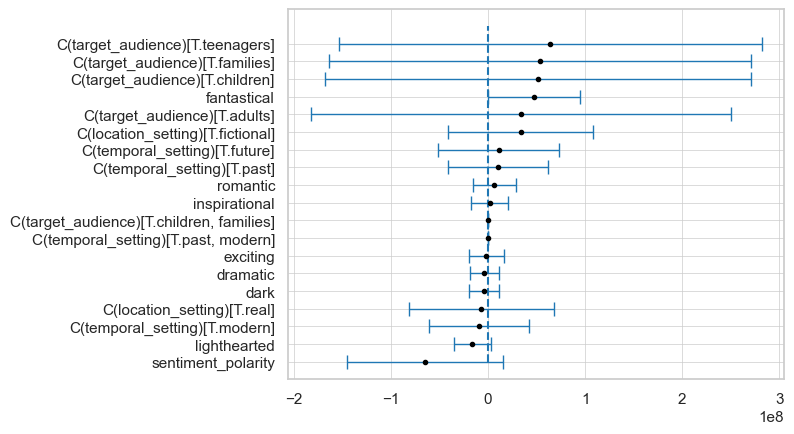

In [134]:
#fancy plotting

plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')

plt.yticks(range(len(l2)),l2);

## Some basic analysis

In [135]:
revenues_df.columns

Index(['movie_wikipedia_id', 'movie_freebase_id', 'movie_name', 'release_year',
       'revenue', 'runtime', 'languages', 'countries', 'genres',
       'plot_summary', 'word_count', 'char_count', 'avg_word_length',
       'sentence_count', 'lexical_diversity', 'sentiment_polarity', 'mood',
       'target_audience', 'temporal_setting', 'location_setting', 'dark',
       'dramatic', 'exciting', 'fantastical', 'inspirational', 'lighthearted',
       'romantic'],
      dtype='object')

In [138]:
revenues_df['target_audience'].unique()

array(['adults', 'teenagers', 'families', 'children', '',
       'children, families', nan], dtype=object)

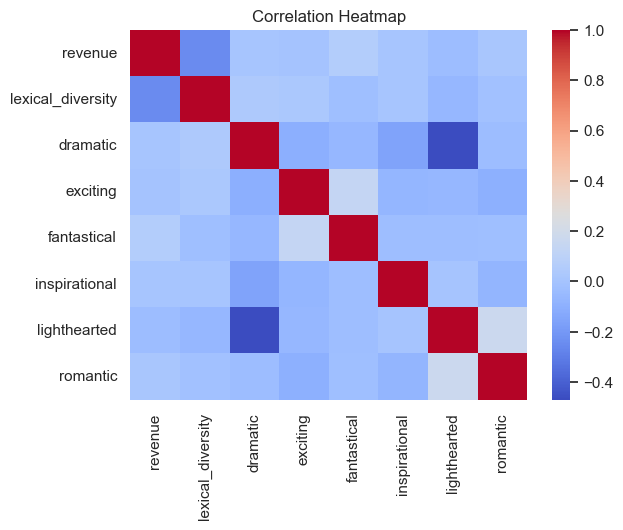

In [139]:
# Compute the correlation matrix
corr = revenues_df[['revenue', 'lexical_diversity',
       'dramatic', 'exciting', 'fantastical', 'inspirational', 'lighthearted',
       'romantic']].corr()

# Generate a heatmap
sns.heatmap(corr, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [145]:
revenues_df.groupby('target_audience')['movie_name'].count()

target_audience
                         1
adults                4231
children               220
children, families       4
families               612
teenagers              498
Name: movie_name, dtype: int64

In [147]:
revenues_df.groupby('target_audience')['revenue'].mean()

target_audience
                      4.409042e+06
adults                4.837064e+07
children              1.034167e+08
children, families    1.874976e+08
families              8.974046e+07
teenagers             6.592313e+07
Name: revenue, dtype: float64

## Children movies are adding odds on revenues

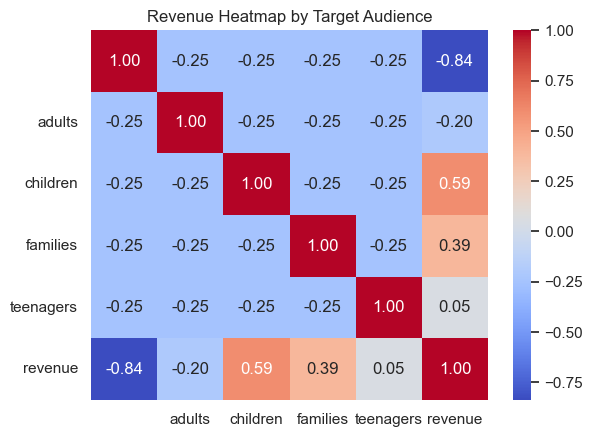

In [146]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'revenues_df' and the one-hot encoding has been performed
# and you have a new DataFrame named 'audience_encoded_df'

# Calculate the mean revenue for each type of audience
audience_revenue = revenues_df[revenues_df['target_audience'] != 'children, families'].groupby('target_audience')['revenue'].mean()

# Create a DataFrame from the audience_revenue series
audience_revenue_df = audience_revenue.reset_index()

# Perform one-hot encoding on the 'target_audience' column
audience_encoded_df = pd.get_dummies(audience_revenue_df['target_audience'])

# Combine the mean revenue with the encoded audience DataFrame
combined_df = pd.concat([audience_encoded_df, audience_revenue_df['revenue']], axis=1)

# Now, create the heatmap
sns.heatmap(combined_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Revenue Heatmap by Target Audience')
plt.show()


In [154]:
revenues_df.columns[20:]

Index(['dark', 'dramatic', 'exciting', 'fantastical', 'inspirational',
       'lighthearted', 'romantic'],
      dtype='object')

## Mood analysis

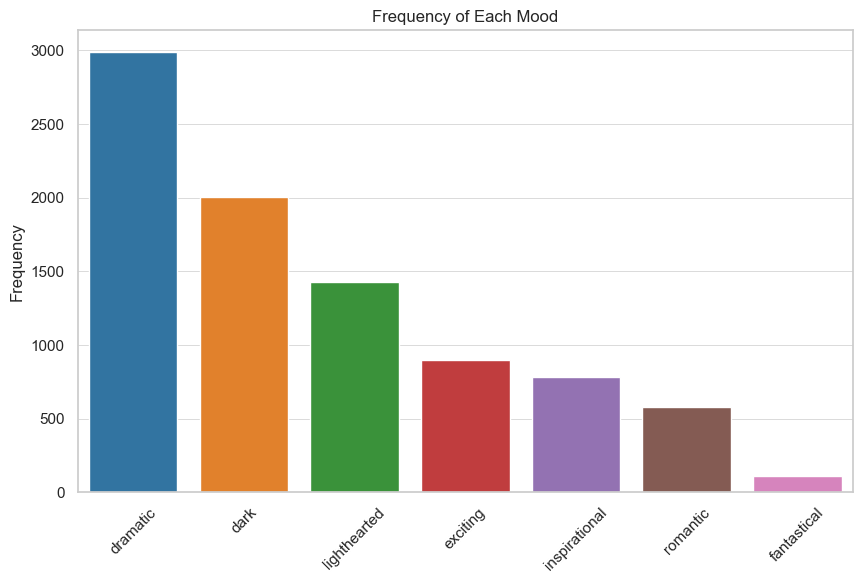

In [156]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'revenues_df' is your DataFrame with the one-hot encoded mood data

# 1. Frequency Distribution of Moods
mood_frequencies = revenues_df.iloc[:, 20:].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=mood_frequencies.index, y=mood_frequencies.values)
plt.title('Frequency of Each Mood')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [157]:
# 2. Mood Association with Revenue
# Assuming there's a 'revenue' column in 'revenues_df'
for mood in mood_frequencies.index:
    average_revenue = revenues_df[revenues_df[mood] == 1]['revenue'].mean()
    print(f"Average revenue for movies with mood {mood}: {average_revenue}")

Average revenue for movies with mood dramatic: 54783739.75803982
Average revenue for movies with mood dark: 52884478.57399103
Average revenue for movies with mood lighthearted: 46669154.23509934
Average revenue for movies with mood exciting: 53045308.08717949
Average revenue for movies with mood inspirational: 55677935.97802198
Average revenue for movies with mood romantic: 58874991.03418803
Average revenue for movies with mood fantastical: 104278787.54545455


In [169]:
# 3. Mood Combinations
# This can be a bit more complex, as it involves looking at rows with multiple moods
# For simplicity, let's look at pairs of moods
from itertools import combinations

# Create a list of all mood columns
mood_columns = revenues_df.columns[20:]

# Generate all pairs of moods
mood_pairs = list(combinations(mood_columns, 2))

# Now, let's count the frequency of each pair
mood_pair_counts = {}
for pair in mood_pairs:
    # Count the number of times each pair occurs together
    mood_pair_counts[pair] = revenues_df[(revenues_df[pair[0]] == 1) & (revenues_df[pair[1]] == 1)].shape[0]

# Convert to a series to sort and plot
mood_pair_counts = pd.Series(mood_pair_counts).sort_values(ascending=False)
mood_pair_counts.isna().any()

# # Plot the most common mood pairs
# plt.figure(figsize=(10, 6))
# sns.barplot(x=mood_pair_counts.head(10).index, y=mood_pair_counts.head(10).values)
# plt.title('Most Common Mood Pairs')
# plt.ylabel('Frequency')
# plt.xticks(rotation=45)
# plt.show()

False

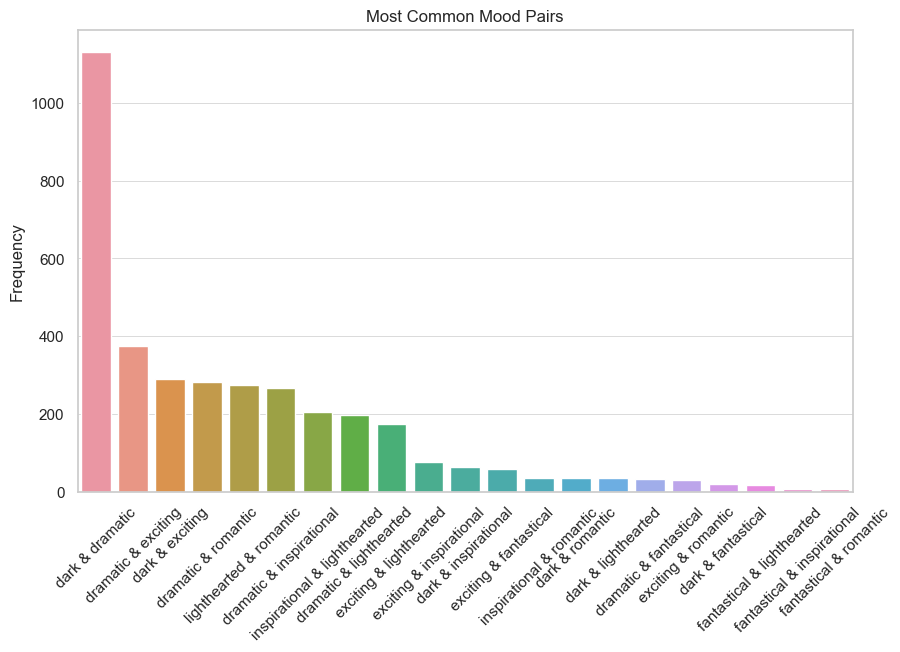

In [171]:
# Plot the most common mood pairs
plt.figure(figsize=(10, 6))

# Convert the tuple index into a string so it can be properly displayed by seaborn's barplot
mood_pair_counts_head = mood_pair_counts
mood_pairs_str = [f"{mood1} & {mood2}" for mood1, mood2 in mood_pair_counts_head.index]

sns.barplot(x=mood_pairs_str, y=mood_pair_counts_head.values)
plt.title('Most Common Mood Pairs')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()
